In [ ]:
# Correct path in order to find tools
import sys
import os
sys.path.append(os.path.abspath(os.path.join(globals()['_dh'][0], '..')))

import numpy as np
#import control as ctrl
#import time

#from scipy.io import loadmat
#from scipy.fft import fft, fftfreq, fftshift
#from scipy.signal import lfilter
from matplotlib import pyplot as plt
from analysis import *
from modelling import *
from HelpFunc import *

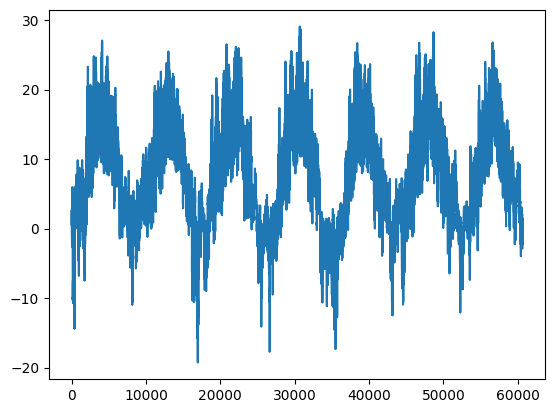

In [216]:
data = mat2np("DataForLabs/projectData24.mat")
year, month, day, hour = [], [], [], []
shortwaveRad = []
netRad = []
heatFlux = []
airTemp = []


for line in data:
    year.append(line[0])
    month.append(line[1])
    day.append(line[2])
    hour.append(line[3])
    shortwaveRad.append(line[4])
    netRad.append(line[5])
    heatFlux.append(line[6])
    airTemp.append(line[7])

year = np.array(year)
month = np.array(month)
day = np.array(day)
hour = np.array(hour)
shortwaveRad = np.array(shortwaveRad)
netRad = np.array(netRad)
heatFlux = np.array(heatFlux)
airTemp = np.array(airTemp)

plt.plot(airTemp)
plt.show()

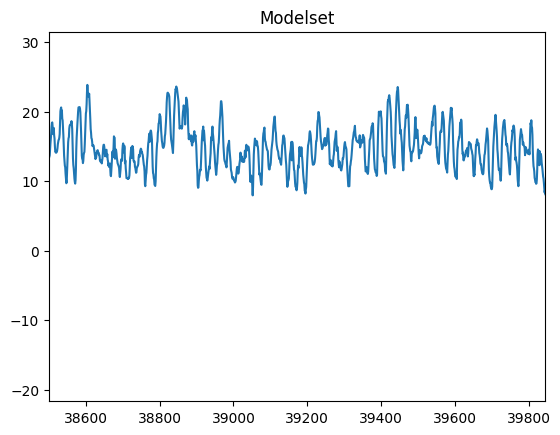

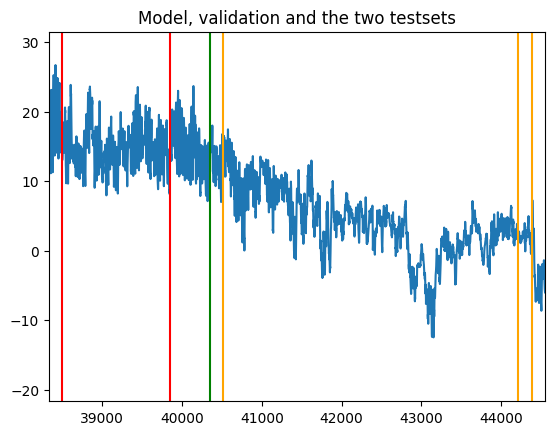

In [294]:
# Choose the model, validation and testset
plt.figure(1)
plt.title("Modelset")
plt.plot(airTemp)
interval = 8*7*24
init = 38500
nbrWeeksValid = 3
plt.xlim([init,init+interval])

modelData = airTemp[init:init+interval]
validData = airTemp[init+interval:init+interval+nbrWeeksValid*7*24]
testData1 = airTemp[init+interval+3*7*24:init+interval+4*7*24]

test2Start = 26

testData2 = airTemp[init+interval+test2Start*7*24: init+interval+(test2Start+1)*7*24]

plt.figure(2)
plt.plot(airTemp)
plt.axvline(init, color="r")
plt.axvline(init+interval, color="r")
plt.axvline(init+interval+nbrWeeksValid*7*24, color="g")
plt.axvline(init+interval+(nbrWeeksValid+1)*7*24, color="orange")
plt.axvline(init+interval+(test2Start+1)*7*24, color="orange")
plt.axvline(init+interval+(test2Start)*7*24, color="orange")
plt.xlim([init-24*7, init+interval+(test2Start+2)*7*24])
plt.title("Model, validation and the two testsets")

plt.show()

[13.34 13.5  13.72 ...  9.79  8.95  8.36]
Discrete-time ARMA model: A(z)y(t) = C(z)e(t)

A(z) = 1.0 - 1.3246(±0.0258)·z⁻¹ + 0.3532(±0.0257)·z⁻² - 0.0582(±0.0144)·z⁻²³ - 0.7743(±0.0435)·z⁻²⁴ + 1.0254(±0.056)·z⁻²⁵ - 0.1963(±0.0358)·z⁻²⁶ - 0.0253(±0.0119)·z⁻²⁷
C(z) = 1.0 - 0.752(±0.0363)·z⁻²⁴

Polynomial orders: nA = 27    nC = 24
Number of free coefficients: 8
Fit to estimation data (NRMSE): 80.68%
FPE : 0.357  MSE : 0.352
AIC : 2379.873   BIC : 2421.338



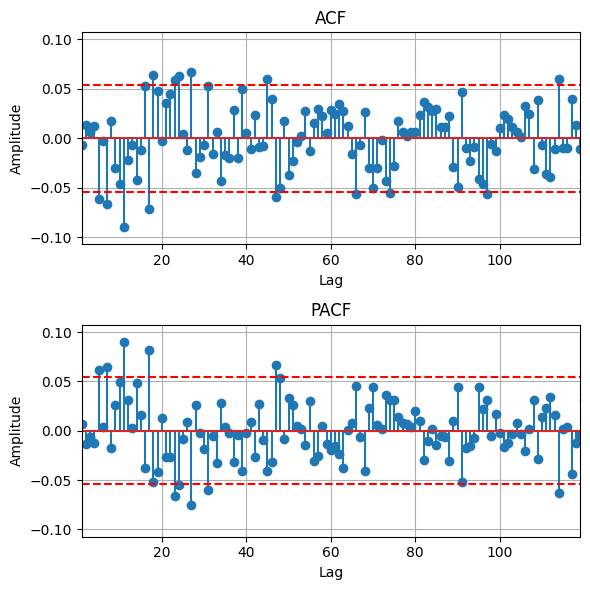

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 48.55 < 31.41)
  McLeod-Li test:        False (white if 149.10 < 31.41)
  Monti test:            False (white if 48.21 < 31.41)
  Sign change test:      True (white if 0.47 in [0.47,0.53])


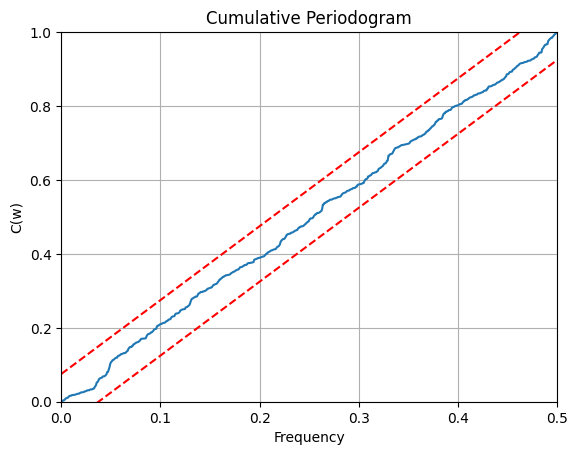

In [295]:
# We are suffering from outliers
print(modelData)
"""
plt.figure(1)
plt.title("ModelData, init = 38500")
plt.plot(acf(modelData), label ="ACF")
plt.plot(tacf(modelData), label = "TACF")
plt.legend()
plt.figure(2)
plt.title("Sorted modeldata, init = 38500")
sortData = np.sort(modelData)
plt.plot(sortData)
plt.show()
"""

s = 24

A = [1, 1, 1]
C = [1]

    

A = np.convolve(A,  [1] + [0]*(s-2) + [-1]*3 )
#A = np.convolve(A, [1, -1])
C = np.convolve(C, [1] + [0]*(s-1) + [-1] )

model = estimateARMA(modelData, A=A, C=C, noLags=120)
#plt.show()
    

368
White noise variance: 0.09289920012599448
Variance of original signal: 0.9274807787698413
Variance of prediction residual: 1.1003651915528703
Ammount of signal that was predicted: -18.64021516568066 %
Naive variation: 1.5418163123582769
Ammount predicted by naive: -66.23700972037997 %


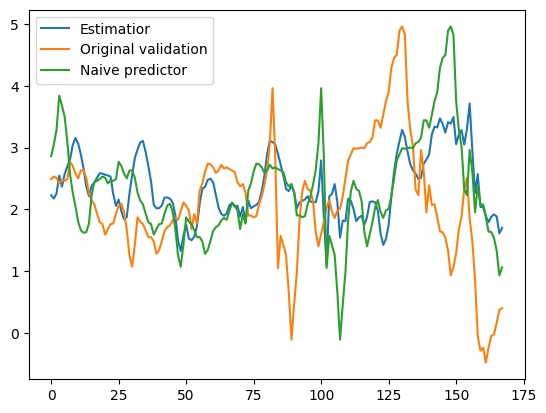

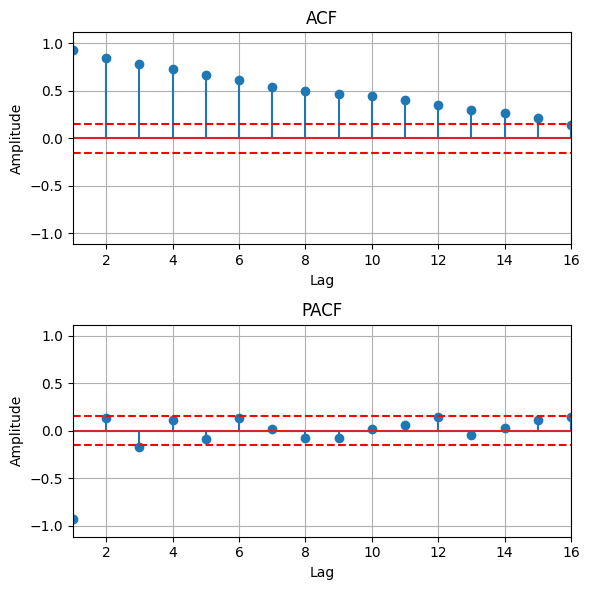

In [296]:
# Performing some k-step predictions 

k = 18
# predData = airTemp[init:init+interval+nbrWeeksValid*7*24]
predData = airTemp[init+interval+test2Start*7*24-200: init+interval+(test2Start+1)*7*24]
A = model.A
C = model.C

print(np.size(predData))

def naive_pred(data, data_ind_start, k_step, season_k=None):
    """
    Computes the naive k-step predictor for the given data. If the optional
    parameter `season_k` is provided, the prediction is based on the corresponding
    value from the last season. Otherwise, it is based on the current value.
    
    Parameters:
        data (array-like): The input time-series data.
        data_ind (array-like): Indices of the data used to compute the variance.
        k_step (int): The number of steps ahead for the naive prediction.
        season_k (int, optional): Seasonal lag, if applicable.
        
    Returns:
        tuple:
            naive_pred (numpy.ndarray): The naive predictions for the indices specified in `data_ind`.
            var_naive (float): The variance of the prediction residuals.
            ehat (numpy.ndarray): The prediction residuals.
    """
    # Ensure data is a numpy array and reshape to a column vector
    data = np.array(data).reshape(-1)
    
    # Compute naive predictor
    if season_k is None:
        naive_pred_full = np.concatenate((np.zeros(k_step), data[:-k_step]))
    else:
        naive_pred_full = np.concatenate((np.zeros(season_k + k_step), data[:-(season_k + k_step)]))
    
    # Retain only relevant indices
    naive_pred = naive_pred_full[data_ind_start:]
    
    # Compute prediction residuals and variance
    ehat = data[data_ind_start:] - naive_pred
    var_naive = np.var(ehat)
    
    return naive_pred, var_naive, ehat

def k_predictor(C, A, k, data, validStart):

    Fk, Gk = polydiv(C, A, k)

    yhat_k = filter(Gk, C, data, axis=0)

    err = np.subtract(data, yhat_k) 

    err = err[validStart:]
    return err, Fk, yhat_k[validStart:]

sig2 , f1, y1k = k_predictor(C, A, 1, predData, 200)
sig2 = np.var(sig2)
print("White noise variance: " + str(sig2))

ek, fk, yhat_k = k_predictor(C, A, k, predData, 200)
naive, var_naive, ehat = naive_pred(predData, 200, k)

varek = np.var(ek)
print("Variance of original signal: " + str(np.var(predData[200:])))
print("Variance of prediction residual: " + str(np.var(ek)))
print("Ammount of signal that was predicted: " + str((1 - np.var(ek)/np.var(predData[200:]))*100) + " %")
print("Naive variation: " + str(var_naive))
print("Ammount predicted by naive: " + str((1 - var_naive/np.var(predData[200:]))*100) + " %")

plt.figure(1)
plt.plot(yhat_k, label="Estimatior")
plt.plot(predData[200:], label="Original validation")
plt.plot(naive, label="Naive predictor")
#plt.xlim([100, 200])
plt.legend()

plt.show()
estimateARMA(ek, A=0, C=0)